## References
- **[Calculate indicators](#Calculate-indicators)**
    - [Return](#Return)
    - [RSI](#RSI)
    - [Gain/lose](#Gain/lose)
    - [Average gain/loss](#Average-gain/loss)
    - [MA](#MA)
    - [Moving Average Convergence Divergence (MACD)](#Moving-Average-Convergence-Divergence-(MACD))
    - [Stochastic Oscillator](#Stochastic-Oscillator)
    - [Williams %R ('r_percent')](#Williams-%R-('r_percent'))
    - [Bollinger Bands](#Bollinger-Bands)

<br>
    
- **[Fuzzyfication and backtesting](#Fuzzyfication-and-backtesting)**

    - [RSI](#RSI-decision)
        - [RSI backtesting](#RSI-backtesting)
    - [Williams %R ('r_percent')](#Williams-%R-('r_percent'))
        - [Williams backtesting](#Williams-backtesting)
     - [MA](#MA-decision)
        - [MA backtesting](#MA-backtesting)
    - [MACD](#MACD-decision)
        - [MACD backtesting](#MACD-backtesting)
    - [Bollinger Bands](#Bollinger-Bands-decision)
        - [Bollinger Bands](#Bollinger-Bands-backtesting)

    
   


***

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import glob
import os
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import simpful as sf
from simpful import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy, TrailingStrategy

import warnings
warnings.filterwarnings("ignore")

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "MAGISTERKA"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="jpg", resolution=400):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data download

In [19]:
stocks = ['EURUSD=X', '^GSPC']

start_data = '2020-01-01'  # (RRR-MM-DD)
end_data = '2024-01-01'  # (RRR-MM-DD)

for stock in stocks:
    data = yf.download(stock, start_data, end_data)
    df = pd.DataFrame(data)
    df['Name'] = stock  # add column with symbol
    df.to_csv(stock + '.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### Load data

In [20]:
data = pd.read_csv('EURUSD=X.csv')

In [21]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2020-01-01,1.122083,1.122838,1.115947,1.122083,1.122083,0,EURUSD=X
1,2020-01-02,1.121894,1.122712,1.116682,1.122083,1.122083,0,EURUSD=X
2,2020-01-03,1.117081,1.118068,1.112570,1.117144,1.117144,0,EURUSD=X
3,2020-01-06,1.116246,1.120825,1.115810,1.116196,1.116196,0,EURUSD=X
4,2020-01-07,1.119583,1.119946,1.113487,1.119799,1.119799,0,EURUSD=X


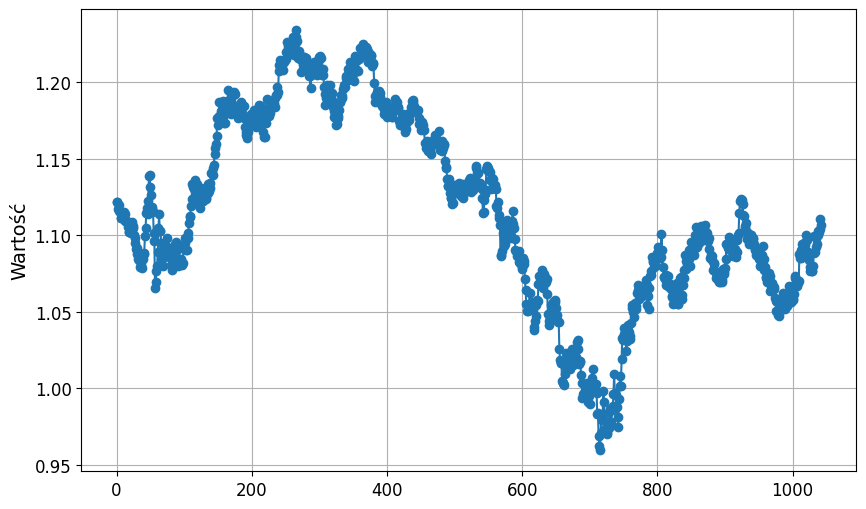

In [22]:
plt.figure(figsize=(10, 6)) 
plt.plot(data.index, data['Close'], marker='o') 
plt.ylabel('Wartość') 
plt.grid(True) 
plt.show()

# Calculate indicators

## Return

In [23]:
price_data = data

In [24]:
# Identify rows where the symbol changes
mask = price_data['Name'] != price_data['Name'].shift(1)

# Calculate log return
price_data['Return'] = np.log(price_data['Close']) -  np.log(price_data['Close'].shift(1))

# For rows where symbol changes set null
price_data['Return'] = np.where(mask == True, np.nan, price_data['Return'])


## Gain/lose


In [25]:
# Set '0' if 'Up' is below 0
price_data['Up'] = price_data['Return']
price_data.loc[(price_data['Up']<0), 'Up'] = 0
 
# Set '0' if 'Down' above 0
price_data['Down'] = price_data['Return']
price_data.loc[(price_data['Down']>0), 'Down'] = 0 
 
# Set the absolute value for negative values
price_data['Down'] = abs(price_data['Down'])

## Average gain/loss

In [26]:
# 14-days averages
price_data['avg_14up'] = price_data.groupby('Name')['Up'].transform(lambda x: x.rolling(window=14).mean())
price_data['avg_14down'] = price_data.groupby('Name')['Down'].transform(lambda x: x.rolling(window=14).mean())


## RSI

In [27]:
# Calculate RS

price_data['RS_14'] = price_data['avg_14up'] / price_data['avg_14down']

# Calculate RSI

price_data['RSI'] = 100 - (100/(1 + price_data['RS_14']))

## MA

In [28]:
price_data["5MA"] = price_data.groupby('Name')['Close'].transform(lambda x: x.rolling(window = 5).mean())
price_data["15MA"] = price_data.groupby('Name')['Close'].transform(lambda x: x.rolling(window = 15).mean())

## Moving Average Convergence Divergence (MACD)

In [29]:
# Calculate 12 and 26 EWM
price_data['12Ewm'] = price_data.groupby('Name')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
price_data['26Ewm'] = price_data.groupby('Name')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

# Calculate MACD
price_data['MACD'] = price_data['12Ewm'] - price_data['26Ewm']


## Stochastic Oscillator

In [30]:
# Period
n = 14

# Group by the symbol and then take max and min 
price_data['low_14'] = price_data.groupby('Name')['Low'].transform(lambda x: x.rolling(window = n).min())
price_data['high_14'] = price_data.groupby('Name')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the stochastic oscillator
price_data['k_percent']  = 100 * ((price_data['Close'] - price_data['low_14']) / (price_data['high_14'] - price_data['low_14']))

## Williams %R ('r_percent')

In [31]:
# Period
n = 14

# Calculate Williams %R
price_data['r_percent'] = -100 * ((price_data['high_14'] - price_data['Close']) / (price_data['high_14'] - price_data['low_14']))



## Bollinger Bands
[Bollinger Bands](https://tcoil.info/compute-bollinger-bands-for-stocks-with-python-and-pandas/)

In [32]:
def bollinger_bands(df, n, m):
    result = df.copy()  
    
    # Initialize new columns with NaN values
    result['B_MA'] = np.nan
    result['BU'] = np.nan
    result['BL'] = np.nan
    
    grouped = df.groupby('Name')
    
    for name, group in grouped:
        data = group['Close']
        
        B_MA = data.rolling(n, min_periods=n).mean()
        sigma = data.rolling(n, min_periods=n).std()
        
        BU = B_MA + m * sigma
        BL = B_MA - m * sigma
        
        # Assign calculated values to the corresponding rows in the result DataFrame
        result.loc[group.index, 'B_MA'] = B_MA
        result.loc[group.index, 'BU'] = BU
        result.loc[group.index, 'BL'] = BL
    
    return result

In [33]:
n = 20   # datapoint rolling window
m = 2    # sigma width
df = bollinger_bands(price_data, 20, 2)

In [34]:
df.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,...,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL
0,2020-01-01,1.122083,1.122838,1.115947,1.122083,1.122083,0,EURUSD=X,NaN,NaN,...,1.122083,1.122083,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,1.121894,1.122712,1.116682,1.122083,1.122083,0,EURUSD=X,0.000000,0.000000,...,1.122083,1.122083,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-03,1.117081,1.118068,1.112570,1.117144,1.117144,0,EURUSD=X,-0.004411,0.000000,...,1.121323,1.121717,-0.000394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-06,1.116246,1.120825,1.115810,1.116196,1.116196,0,EURUSD=X,-0.000849,0.000000,...,1.120534,1.121308,-0.000774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-07,1.119583,1.119946,1.113487,1.119799,1.119799,0,EURUSD=X,0.003223,0.003223,...,1.120421,1.121196,-0.000775,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-01-08,1.115573,1.116520,1.111086,1.115474,1.115474,0,EURUSD=X,-0.003870,0.000000,...,1.119660,1.120772,-0.001112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-01-09,1.111444,1.112223,1.109509,1.111321,1.111321,0,EURUSD=X,-0.003730,0.000000,...,1.118377,1.120072,-0.001695,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-01-10,1.110926,1.112100,1.108623,1.111111,1.111111,0,EURUSD=X,-0.000189,0.000000,...,1.117259,1.119408,-0.002149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-01-13,1.111655,1.114467,1.111408,1.111667,1.111667,0,EURUSD=X,0.000500,0.000500,...,1.116399,1.118835,-0.002436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-01-14,1.113449,1.114579,1.110556,1.113573,1.113573,0,EURUSD=X,0.001713,0.001713,...,1.115964,1.118445,-0.002481,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
print('Before NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))

# Delete lines with NaN values
df = df.dropna()

# Display how much we have left now
print('After NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))


Before NaN Drop we have 1043 rows and 27 columns
After NaN Drop we have 1024 rows and 27 columns


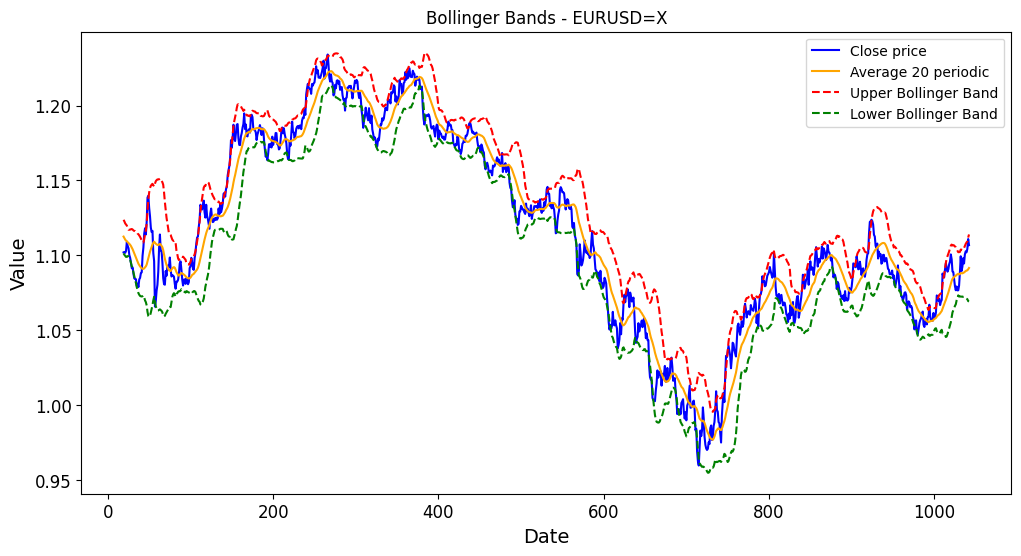

In [36]:
grouped = df.groupby('Name')

for name, group in grouped:
    plt.figure(figsize=(12, 6))
    plt.title(f'Bollinger Bands - {name}')
    
    plt.plot(group.index, group['Close'], label='Close price', color='blue') 
    plt.plot(group.index, group['B_MA'], label=f'Average {n} periodic', color='orange')  
    plt.plot(group.index, group['BU'], label=f'Upper Bollinger Band', color='red', linestyle='--') 
    plt.plot(group.index, group['BL'], label=f'Lower Bollinger Band', color='green', linestyle='--') 
   
    plt.legend()  
    plt.xlabel('Date') 
    plt.ylabel('Value') 
    plt.show()

In [37]:
df[['B_MA', 'BU', 'BL','Close']]

,B_MA,BU,BL,Close
19,1.112515,1.123721,1.101308,1.101977
20,1.111523,1.122674,1.100373,1.102256
21,1.110503,1.121313,1.099693,1.101686
22,1.109792,1.120635,1.098949,1.102913
23,1.109431,1.119849,1.099013,1.108979
...,...,...,...,...
1038,1.089489,1.107607,1.071372,1.102657
1039,1.089799,1.108572,1.071025,1.102026
1040,1.089984,1.109272,1.070696,1.104301
1041,1.090659,1.111882,1.069435,1.110864


## Export file

In [38]:
#df.to_csv("indicators_eurusd_d.csv", index=False, encoding='utf-8-sig')
df.to_csv("indicators_eurusd_d_4Y.csv", index=False, encoding='utf-8-sig')


## [References](#References)

***

# Fuzzyfication and backtesting

- **Start:** Data rozpoczęcia symulacji backtestu.
- **End:** Data zakończenia symulacji backtestu.
- **Duration:** Czas trwania symulacji backtestu.
- **Exposure Time [%]:** Procent czasu, w którym kapitał był inwestowany w rynku.
- **Equity Final [\$]:** Ostateczny kapitał na koniec symulacji.
- **Equity Peak [\$]:** Najwyższy osiągnięty poziom kapitału.
- **Return [%]:** Procentowy zwrot kapitału w trakcie symulacji.
- **Buy & Hold Return [%]:** Procentowy zwrot kapitału w przypadku strategii buy & hold.
- **Return (Ann.) [%]:** Procentowy zwrot kapitału na rok.
- **Volatility (Ann.) [%]:** Procentowa zmienność na rok.
- **Sharpe Ratio:** Wskaźnik Sharpe'a.
- **Sortino Ratio:** Wskaźnik Sortino.
- **Calmar Ratio:** Wskaźnik Calmara.
- **Max. Drawdown [%]:** Maksymalne obniżenie kapitału.
- **Avg. Drawdown [%]:** Średnie obniżenie kapitału.
- **Max. Drawdown Duration:** Okres trwania maksymalnego obniżenia kapitału.
- **Avg. Drawdown Duration:** Średni okres trwania obniżenia kapitału.
- **# Trades:** Liczba przeprowadzonych transakcji.
- **Win Rate [%]:** Procent transakcji z zyskiem.
- **Best Trade [%]:** Najlepszy zysk z pojedynczej transakcji.
- **Worst Trade [%]:** Najgorsza strata z pojedynczej transakcji.
- **Avg. Trade [%]:** Średni zysk lub strata z pojedynczej transakcji.
- **Max. Trade Duration:** Maksymalny czas trwania pojedynczej transakcji.
- **Avg. Trade Duration:** Średni czas trwania pojedynczej transakcji.
- **Profit Factor:** Wskaźnik zysku.
- **Expectancy [%]:** Oczekiwany zysk w każdej transakcji.
- **SQN:** System Quality Number.
- **Kelly Criterion:** Wskaźnik Kelly'ego.


***

In [52]:
df = pd.read_csv('data/indicators_eurusd_d.csv')

In [53]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,...,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL
0,2018-02-28,1.222210,1.224290,1.218918,1.223032,1.223032,0,EURUSD=X,-0.006946,0.000000,...,1.232730,1.235763,-0.003033,1.218918,1.255808,11.153299,-88.846701,1.235611,1.252466,1.218756
1,2018-03-01,1.219096,1.222180,1.215800,1.219126,1.219126,0,EURUSD=X,-0.003199,0.000000,...,1.230637,1.234531,-0.003894,1.215800,1.255808,8.313370,-91.686630,1.234474,1.252574,1.216374
2,2018-03-02,1.227129,1.233046,1.225280,1.227084,1.227084,0,EURUSD=X,0.006507,0.006507,...,1.230090,1.233979,-0.003889,1.215800,1.255808,28.205747,-71.794253,1.233278,1.249879,1.216677
3,2018-03-05,1.231846,1.234827,1.227551,1.231542,1.231542,0,EURUSD=X,0.003626,0.003626,...,1.230314,1.233799,-0.003485,1.215800,1.255808,39.348243,-60.651757,1.232620,1.248335,1.216905
4,2018-03-06,1.233776,1.241989,1.233122,1.233654,1.233654,0,EURUSD=X,0.001713,0.001713,...,1.230828,1.233788,-0.002960,1.215800,1.255808,44.626895,-55.373105,1.232464,1.248066,1.216862


## RSI decision


In [54]:
data = df

In [55]:
def decision_rsi(df):
    df['dec_rsi'] = 'HOLD'  

    df.loc[df['RSI'] < 30, 'dec_rsi'] = 'BUY'
    df.loc[df['RSI'] > 70, 'dec_rsi'] = 'SELL'

    return df

In [56]:
decision_rsi(data)
data['dec_rsi'].value_counts()

dec_rsi
HOLD    1216
BUY      190
SELL     139
Name: count, dtype: int64

In [57]:
FS = sf.FuzzySystem()


# linguistic variable for the input
S1 = sf.FuzzySet(points=[[0, 1.], [30, 1.], [50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[50, 1.], [51, 1.], [61, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[61, 0.], [70, 1.], [100, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 100])
FS.add_linguistic_variable("RSI", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_RSI_fuzz_system", LV)


R1 = "IF (RSI IS low) THEN (Signal_RSI_fuzz_system IS SELL)"
R2 = "IF (RSI IS medium) THEN (Signal_RSI_fuzz_system IS HOLD)"
R3 = "IF (RSI IS high) THEN (Signal_RSI_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

data['Signal_RSI_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['RSI']):
    FS.set_variable("RSI", value)
    decision = FS.Mamdani_inference()['Signal_RSI_fuzz_system']
    
    if decision <= 0.3:
        data.loc[data.index[i], 'Signal_RSI_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'Signal_RSI_fuzz_system'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



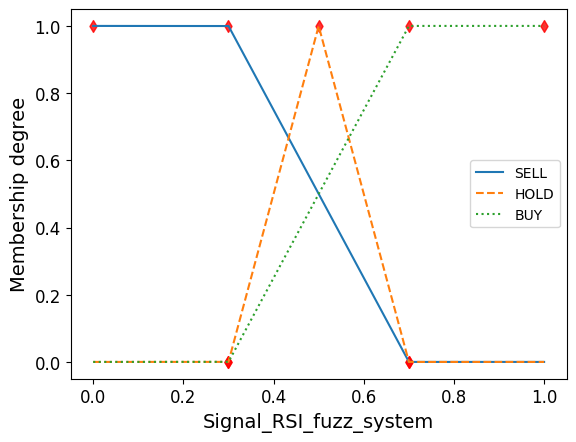

In [58]:
FS.plot_variable('Signal_RSI_fuzz_system')

In [59]:
data['Signal_RSI_fuzz_system'].value_counts()

Signal_RSI_fuzz_system
HOLD    1125
SELL     211
BUY      209
Name: count, dtype: int64

## RSI backtesting

## Sharp

In [60]:
# zmiana na datę i ustaw jako index
data = data.set_index(pd.DatetimeIndex(data['Date']))
# zmiana decyzji na -1, 0, 1
data['dec_rsi'] = data['dec_rsi'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

In [61]:
class CustomStrategy(SignalStrategy, TrailingStrategy):
    def init(self):
        super().init()
        self.set_signal(data['dec_rsi'])

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   95.728155
Equity Final [$]                  9996.114961
Equity Peak [$]                  10000.001581
Return [%]                           -0.03885
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.006338
Volatility (Ann.) [%]                 0.00889
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.049795
Avg. Drawdown [%]                   -0.025199
Max. Drawdown Duration     2088 days 00:00:00
Avg. Drawdown Duration     1050 days 00:00:00
# Trades                                  239
Win Rate [%]                        34.309623
Best Trade [%]                       9.385401
Worst Trade [%]                     -6.385485
Avg. Trade [%]                    

In [62]:
data['Signal_RSI_fuzz_system'] = data['Signal_RSI_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy, TrailingStrategy):
    def init(self):
        super().init()
        self.set_signal(data['Signal_RSI_fuzz_system'])

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                    95.92233
Equity Final [$]                 10003.100219
Equity Peak [$]                  10008.449246
Return [%]                           0.031002
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                    0.005056
Volatility (Ann.) [%]                0.027588
Sharpe Ratio                          0.18327
Sortino Ratio                        0.253698
Calmar Ratio                         0.094451
Max. Drawdown [%]                    -0.05353
Avg. Drawdown [%]                   -0.008302
Max. Drawdown Duration      491 days 00:00:00
Avg. Drawdown Duration       69 days 00:00:00
# Trades                                  317
Win Rate [%]                        47.318612
Best Trade [%]                      14.724154
Worst Trade [%]                     -7.525865
Avg. Trade [%]                    

In [63]:
class CustomStrategy(SignalStrategy):
    
    def init(self):
        super().init()
        signal = self.set_signal(data['dec_rsi'])
        if signal == 1: #rozne od self.position.long
            self.buy(size=.4, sl=.9)
        elif signal == -1:
            self.sell(size=.4, sl=.9)
        super().next()


        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   97.087379
Equity Final [$]                  9999.081645
Equity Peak [$]                   9999.997544
Return [%]                          -0.009159
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.001494
Volatility (Ann.) [%]                0.000794
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.009164
Avg. Drawdown [%]                   -0.009164
Max. Drawdown Duration     2100 days 00:00:00
Avg. Drawdown Duration     2100 days 00:00:00
# Trades                                  328
Win Rate [%]                         34.45122
Best Trade [%]                       3.345059
Worst Trade [%]                     -4.160291
Avg. Trade [%]                    

## Fuzzy

In [64]:
# zmiana decyzji na -1, 0, 1
data['Signal_RSI_fuzz_system'] = data['Signal_RSI_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        
        self.set_signal(data['Signal_RSI_fuzz_system'] * 0.5)
      
    
    #    size = 0.5  
     #   if self.set_signal == 1:
      #      self.buy(size=size)
       # elif self.set_signal == -1:
        #    self.sell(size=size)
       # super().next()
        
# dodać warunki zmieniające size
# set signal dodac rozmiar wejscia
bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   97.087379
Equity Final [$]                  6493.426397
Equity Peak [$]                  10012.796045
Return [%]                         -35.065736
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -6.800577
Volatility (Ann.) [%]                3.397604
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -35.198193
Avg. Drawdown [%]                   -9.407771
Max. Drawdown Duration     1995 days 00:00:00
Avg. Drawdown Duration      526 days 00:00:00
# Trades                                  418
Win Rate [%]                        33.492823
Best Trade [%]                       4.171154
Worst Trade [%]                     -3.196263
Avg. Trade [%]                    

# Williams %R ('r_percent')


In [65]:
def decision_williams(df):
    df['dec_will'] = 'HOLD'  

    df.loc[df['r_percent'] < -80, 'dec_will'] = 'BUY'
    df.loc[df['r_percent'] > -20, 'dec_will'] = 'SELL'

    return df

In [66]:
decision_williams(data)
data['dec_will'].value_counts()

dec_will
HOLD    961
BUY     323
SELL    261
Name: count, dtype: int64

In [67]:
FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-100, 1.], [-80, 1.], [-50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-50, 1.], [-49, 1.], [-39, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[-39, 0.], [-20, 1.], [0, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-100, 0])
FS.add_linguistic_variable("r_percent", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_william_fuzz_system", LV)


R1 = "IF (r_percent IS low) THEN (Signal_william_fuzz_system IS SELL)"
R2 = "IF (r_percent IS medium) THEN (Signal_william_fuzz_system IS HOLD)"
R3 = "IF (r_percent IS high) THEN (Signal_william_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

data['Signal_william_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['r_percent']):
    FS.set_variable("r_percent", value)
    decision = FS.Mamdani_inference()['Signal_william_fuzz_system']
    
    if decision <= 0.3:
        data.loc[data.index[i], 'Signal_william_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'Signal_william_fuzz_system'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



# Williams backtesting

### Sharp

In [84]:
# zmiana decyzji na -1, 0, 1
data['dec_will'] = data['dec_will'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        
        self.set_signal(data['dec_will'])
      

        
# dodać warunki zmieniające size
# set signal dodac rozmiar wejscia
bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   99.288026
Equity Final [$]                 10002.426442
Equity Peak [$]                  10004.073273
Return [%]                           0.024264
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                    0.003957
Volatility (Ann.) [%]                0.035427
Sharpe Ratio                         0.111702
Sortino Ratio                        0.161555
Calmar Ratio                         0.041649
Max. Drawdown [%]                   -0.095016
Avg. Drawdown [%]                   -0.010271
Max. Drawdown Duration      692 days 00:00:00
Avg. Drawdown Duration       93 days 00:00:00
# Trades                                  322
Win Rate [%]                        50.931677
Best Trade [%]                       13.78058
Worst Trade [%]                    -14.239084
Avg. Trade [%]                    

### Fuzzy

In [69]:
data['Signal_william_fuzz_system'].value_counts()

Signal_william_fuzz_system
HOLD    780
BUY     405
SELL    360
Name: count, dtype: int64

In [85]:
data['Signal_william_fuzz_system'] = data['Signal_william_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['Signal_william_fuzz_system'])

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   99.029126
Equity Final [$]                   9991.23022
Equity Peak [$]                  10000.878372
Return [%]                          -0.087698
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.014309
Volatility (Ann.) [%]                0.024227
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.108521
Avg. Drawdown [%]                   -0.015403
Max. Drawdown Duration     1119 days 00:00:00
Avg. Drawdown Duration      240 days 00:00:00
# Trades                                  405
Win Rate [%]                        31.111111
Best Trade [%]                       9.003645
Worst Trade [%]                    -12.479648
Avg. Trade [%]                    

# MA decision



kupno - krótsza przecina dłuższą od dołu 

sprzedaż - krótsza przecina dłuższą od góry


In [71]:
# Ostre

data['prev_5MA'] = data['5MA'].shift(1)

data['crossover'] = np.where((data['5MA'] > data['15MA']) & (data['prev_5MA'] < data['15MA']), 'bullish crossover',
                                  np.where((data['5MA'] < data['15MA']) & (data['prev_5MA'] > data['15MA']), 'bearish crossover', None))

data['cross_MA'] = np.where(data['crossover'] == 'bullish crossover', 'BUY', 
                                          np.where(data['crossover'] == 'bearish crossover', 'SELL', 'HOLD'))

data['crossover'].value_counts()



crossover
bearish crossover    78
bullish crossover    68
Name: count, dtype: int64

In [72]:
# Calculating the difference between the shorter and longer average

data['diff_MA'] = data['5MA'] - data['15MA']

# Creation of 1 lagged column with difference in averages
data['diff_MA_prev'] = data['diff_MA'].shift(1)

data['diff_MA'].describe()

count    1545.000000
mean       -0.000481
std         0.007046
min        -0.029886
25%        -0.005046
50%        -0.000461
75%         0.003504
max         0.026677
Name: diff_MA, dtype: float64

In [73]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MA około 0 i diff_MA_prev < 0 - BUY
Jeśli diff_MA około 0 i diff_MA_prev > 0 - SELL
'''

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [-0.000060, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-0.001, 0.], [0, 1.], [0.001, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0.001, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MA", LV)
FS.add_linguistic_variable("diff_MA_prev", LV)


# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_MA_strategy", LV)

R1 = "IF (diff_MA IS medium) AND (diff_MA_prev IS low) THEN (fuzz_MA_strategy IS BUY)"
R2 = "IF (diff_MA IS medium) AND (diff_MA_prev IS high) THEN (fuzz_MA_strategy IS SELL)"
R3 = "IF (diff_MA IS low) THEN (fuzz_MA_strategy IS HOLD)"
R4 = "IF (diff_MA IS high) THEN (fuzz_MA_strategy IS HOLD)"
FS.add_rules([R1, R2, R3, R4])


data['fuzz_MA_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['diff_MA']):
    FS.set_variable("diff_MA", value)
    FS.set_variable("diff_MA_prev", data.loc[data.index[i], 'diff_MA_prev'])
    decision = FS.Mamdani_inference()['fuzz_MA_strategy']

    if decision <= 0.3:
        data.loc[data.index[i], 'fuzz_MA_strategy'] = 'BUY'
    elif decision >= 0.7:
        data.loc[data.index[i], 'fuzz_MA_strategy'] = 'SELL'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



In [74]:
data['fuzz_MA_strategy'].value_counts()

fuzz_MA_strategy
HOLD    1516
BUY       18
SELL      11
Name: count, dtype: int64

# MA backtesting

## Sharp

In [75]:
data['cross_MA'] = data['cross_MA'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['cross_MA'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   98.964401
Equity Final [$]                  9999.571229
Equity Peak [$]                  10000.049287
Return [%]                          -0.004288
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.000699
Volatility (Ann.) [%]                0.000797
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.005675
Avg. Drawdown [%]                   -0.000695
Max. Drawdown Duration     2072 days 00:00:00
Avg. Drawdown Duration      237 days 00:00:00
# Trades                                  145
Win Rate [%]                        32.413793
Best Trade [%]                        4.91431
Worst Trade [%]                      -2.92273
Avg. Trade [%]                    

## Fuzzy

In [76]:
data['fuzz_MA_strategy'] = data['fuzz_MA_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['fuzz_MA_strategy'])
        
# dodać warunki zmieniające size
# set signal dodac rozmiar wejscia
bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   94.886731
Equity Final [$]                 10000.044373
Equity Peak [$]                  10000.179195
Return [%]                           0.000444
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                    0.000072
Volatility (Ann.) [%]                0.000768
Sharpe Ratio                           0.0942
Sortino Ratio                         0.13382
Calmar Ratio                          0.02439
Max. Drawdown [%]                   -0.002967
Avg. Drawdown [%]                   -0.000275
Max. Drawdown Duration     1036 days 00:00:00
Avg. Drawdown Duration       81 days 00:00:00
# Trades                                   28
Win Rate [%]                        67.857143
Best Trade [%]                       7.396879
Worst Trade [%]                     -7.159433
Avg. Trade [%]                    

# MACD decision

In [77]:
   '''
    Linia MACD przetnie od dołu linię sygnałową - kup
    Linia MACD przetnie od góry linię sygnałową - sprzedaj
    '''
    
data['Signal_Line'] = data.groupby('Name')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

buy_condition = ((data['MACD'].shift(1) < data['Signal_Line'].shift(1)) & 
                 (data['MACD'] > data['Signal_Line']))  
               

sell_condition = ((data['MACD'].shift(1) > data['Signal_Line'].shift(1)) & 
                  (data['MACD'] < data['Signal_Line']))

data['MACD_decision'] = np.where(buy_condition, 1, np.where(sell_condition, -1, 0))

data[['MACD', 'Signal_Line']].describe()

,MACD,Signal_Line
count,1545.000000,1545.000000
mean,-0.000665,-0.000669
std,0.005181,0.004879
min,-0.014496,-0.012347
25%,-0.003936,-0.003662
50%,-0.001198,-0.001303
75%,0.002173,0.001982
max,0.014898,0.013506


In [78]:
# Calculating the difference between MACD and Signal line
data['diff_MACD'] = data['MACD'] - data['Signal_Line']

# Creation of 1 lagged column with the difference in MACD and Signal
data['diff_MACD_prev'] = data['diff_MACD'].shift(1)

In [79]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MACD około 0 (0,001) i diff_MACD_prev < 0 - BUY
Jeśli diff_MACD około 0(0,001) i diff_MACD_prev > 0 - SELL
'''

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [-0.001, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-0.001, 0.], [0, 1.], [0.001, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0.001, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MACD", LV)
FS.add_linguistic_variable("diff_MACD_prev", LV)


# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_MACD_strategy", LV)

R1 = "IF (diff_MACD IS medium) AND (diff_MACD_prev IS low) THEN (fuzz_MACD_strategy IS BUY)"
R2 = "IF (diff_MACD IS medium) AND (diff_MACD_prev IS high) THEN (fuzz_MACD_strategy IS SELL)"
R3 = "IF (diff_MACD IS low) THEN (fuzz_MACD_strategy IS HOLD)"
R4 = "IF (diff_MACD IS high) THEN (fuzz_MACD_strategy IS HOLD)"
FS.add_rules([R1, R2, R3, R4])


data['fuzz_MACD_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['diff_MACD']):
    FS.set_variable("diff_MACD", value)
    FS.set_variable("diff_MACD_prev", data.loc[data.index[i], 'diff_MACD_prev'])
    decision = FS.Mamdani_inference()['fuzz_MACD_strategy']

    if decision <= 0.3:
        data.loc[data.index[i], 'fuzz_MACD_strategy'] = 'BUY'
    elif decision >= 0.7:
        data.loc[data.index[i], 'fuzz_MACD_strategy'] = 'SELL'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



# MACD backtesting

### Sharp

In [80]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['MACD_decision'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   98.964401
Equity Final [$]                  9999.634439
Equity Peak [$]                   10000.03406
Return [%]                          -0.003656
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.000596
Volatility (Ann.) [%]                0.000794
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.004962
Avg. Drawdown [%]                   -0.001099
Max. Drawdown Duration     2072 days 00:00:00
Avg. Drawdown Duration      428 days 00:00:00
# Trades                                  125
Win Rate [%]                             28.8
Best Trade [%]                        4.17545
Worst Trade [%]                     -2.243889
Avg. Trade [%]                    

### Fuzzy

In [81]:
data['fuzz_MACD_strategy'] = data['fuzz_MACD_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['fuzz_MACD_strategy'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                     99.7411
Equity Final [$]                  9999.994589
Equity Peak [$]                  10000.090799
Return [%]                          -0.000054
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.000009
Volatility (Ann.) [%]                0.000795
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.001811
Avg. Drawdown [%]                   -0.000338
Max. Drawdown Duration      857 days 00:00:00
Avg. Drawdown Duration      119 days 00:00:00
# Trades                                   52
Win Rate [%]                        46.153846
Best Trade [%]                       8.165896
Worst Trade [%]                     -4.623008
Avg. Trade [%]                    

## [References](#References)

# Bollinger Bands decision

### Sharp

In [82]:
   '''
   'B_MA',
 'BU',
 'BL',
    close < BL - kup
    close > BU - sprzedaj
    '''
def decision_bollinger(df):
    df['dec_bollinger'] = 'HOLD'  

    df.loc[df['Close'] < df['BL'], 'dec_bollinger'] = 'BUY'
    df.loc[df['Close'] > df['BU'], 'dec_bollinger'] = 'SELL'

    return df

In [83]:
decision_bollinger(data)

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,...,cross_MA,diff_MA,diff_MA_prev,fuzz_MA_strategy,Signal_Line,MACD_decision,diff_MACD,diff_MACD_prev,fuzz_MACD_strategy,dec_bollinger
2018-02-28,2018-02-28,1.222210,1.224290,1.218918,1.223032,1.223032,0,EURUSD=X,-0.006946,0.000000,...,0,-0.004486,NaN,0,-0.003033,0,0.000000,NaN,1,HOLD
2018-03-01,2018-03-01,1.219096,1.222180,1.215800,1.219126,1.219126,0,EURUSD=X,-0.003199,0.000000,...,0,-0.005785,-0.004486,0,-0.003205,0,-0.000688,0.000000,0,HOLD
2018-03-02,2018-03-02,1.227129,1.233046,1.225280,1.227084,1.227084,0,EURUSD=X,0.006507,0.006507,...,0,-0.006969,-0.005785,0,-0.003342,0,-0.000547,-0.000688,0,HOLD
2018-03-05,2018-03-05,1.231846,1.234827,1.227551,1.231542,1.231542,0,EURUSD=X,0.003626,0.003626,...,0,-0.006820,-0.006969,0,-0.003371,0,-0.000114,-0.000547,-1,HOLD
2018-03-06,2018-03-06,1.233776,1.241989,1.233122,1.233654,1.233654,0,EURUSD=X,0.001713,0.001713,...,0,-0.006619,-0.006820,0,-0.003289,1,0.000328,-0.000114,0,HOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-25,2024-01-25,1.088175,1.090037,1.082614,1.088175,1.088175,0,EURUSD=X,0.002196,0.002196,...,0,-0.004026,-0.004253,0,-0.000121,0,-0.001354,-0.001578,0,HOLD
2024-01-26,2024-01-26,1.084705,1.088329,1.081338,1.084705,1.084705,0,EURUSD=X,-0.003194,0.000000,...,0,-0.003999,-0.004026,0,-0.000462,0,-0.001363,-0.001354,0,HOLD
2024-01-29,2024-01-29,1.084352,1.084975,1.079715,1.084352,1.084352,0,EURUSD=X,-0.000325,0.000000,...,0,-0.004317,-0.003999,0,-0.000791,0,-0.001315,-0.001363,0,HOLD
2024-01-30,2024-01-30,1.083447,1.085564,1.081268,1.083447,1.083447,0,EURUSD=X,-0.000835,0.000000,...,0,-0.004450,-0.004317,0,-0.001107,0,-0.001267,-0.001315,0,HOLD


In [34]:
data['dec_bollinger'].value_counts()

dec_bollinger
HOLD    1384
BUY       89
SELL      72
Name: count, dtype: int64

In [35]:
data[['BU', 'BL', 'B_MA', 'Close']]

,BU,BL,B_MA,Close
2018-02-28,1.252466,1.218756,1.235611,1.223032
2018-03-01,1.252574,1.216374,1.234474,1.219126
2018-03-02,1.249879,1.216677,1.233278,1.227084
2018-03-05,1.248335,1.216905,1.232620,1.231542
2018-03-06,1.248066,1.216862,1.232464,1.233654
...,...,...,...,...
2024-01-25,1.106139,1.081962,1.094050,1.088175
2024-01-26,1.104127,1.081762,1.092945,1.084705
2024-01-29,1.101994,1.081773,1.091883,1.084352
2024-01-30,1.099947,1.081776,1.090862,1.083447


### Fuzzy

In [36]:
'''
    diff_cl_BL < 0 - kup
    diff_cl_BU > 0 - sprzedaj
'''

data['diff_cl_BU'] = data['Close'] - data['BU']
data['diff_cl_BL'] = data['Close'] - data['BL']

data['prev_diff_cl_BU'] = data['diff_cl_BU'].shift(1)
data['prev_diff_cl_BL'] = data['diff_cl_BL'].shift(1)


In [37]:
data[['diff_cl_BU', 'diff_cl_BL']].describe()

,diff_cl_BU,diff_cl_BL
count,1545.000000,1545.000000
mean,-0.017032,0.015225
std,0.013835,0.013914
min,-0.082142,-0.011002
25%,-0.024043,0.005740
50%,-0.013950,0.011670
75%,-0.007385,0.020896
max,0.009087,0.080340


In [38]:
# Fuzzy System initialization
FS = sf.FuzzySystem()

# Define linguistic variables for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [0, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[0, 0.], [0, 1.], [0, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_cl_BU", LV)
FS.add_linguistic_variable("diff_cl_BL", LV)
FS.add_linguistic_variable("prev_diff_cl_BU", LV)
FS.add_linguistic_variable("prev_diff_cl_BL", LV)

# Define linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_BB_strategy", LV)

# Define fuzzy rules

R1 = "IF (diff_cl_BU IS medium) AND (prev_diff_cl_BU IS low) THEN (fuzz_BB_strategy IS SELL)"
R2 = "IF (diff_cl_BU IS high) AND (NOT (diff_cl_BU IS low)) THEN (fuzz_BB_strategy IS SELL)"

R3 = "IF (diff_cl_BL IS medium) AND (prev_diff_cl_BL IS low) THEN (fuzz_BB_strategy IS BUY)"
R4 = "IF (diff_cl_BL IS low) AND (prev_diff_cl_BL IS low) THEN (fuzz_BB_strategy IS BUY)"

R5 = "IF (diff_cl_BU IS low) THEN (fuzz_BB_strategy IS HOLD)"
R6 = "IF (diff_cl_BL IS high) THEN (fuzz_BB_strategy IS HOLD)"


FS.add_rules([R1, R2, R3, R4, R5, R6])


# Initialize fuzzy MACD strategy column
data['fuzz_BB_strategy'] = 'HOLD'

# Perform fuzzy inference and generate signals
for i, row in data.iterrows():
    diff_cl_BU = row['diff_cl_BU']
    diff_cl_BU_prev = row['prev_diff_cl_BU']
    diff_cl_BL = row['diff_cl_BL']
    diff_cl_BL_prev = row['prev_diff_cl_BL']

    FS.set_variable("diff_cl_BU", diff_cl_BU)
    FS.set_variable("prev_diff_cl_BU", diff_cl_BU_prev)
    FS.set_variable("diff_cl_BL", diff_cl_BL)
    FS.set_variable("prev_diff_cl_BL", diff_cl_BL_prev)

    decision = FS.Mamdani_inference()['fuzz_BB_strategy']
    if decision >= 0.7:
        data.at[i, 'fuzz_BB_strategy'] = 'BUY'
    elif decision <= 0.3:
        data.at[i, 'fuzz_BB_strategy'] = 'SELL'


  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



### ::: Być może należy dla każdej wstęgi ustalić inne wartości punktowe :::

In [39]:
data['fuzz_BB_strategy'].value_counts()

fuzz_BB_strategy
HOLD    1433
SELL      72
BUY       40
Name: count, dtype: int64

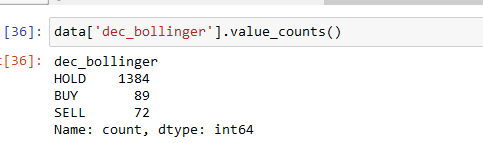

# Bollinger Bands backtesting

In [40]:
data['dec_bollinger'] = data['dec_bollinger'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})
data['fuzz_BB_strategy'] = data['fuzz_BB_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

### Sharp

In [41]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['dec_bollinger'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   97.281553
Equity Final [$]                  9999.740298
Equity Peak [$]                  10000.008056
Return [%]                          -0.002597
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.000424
Volatility (Ann.) [%]                0.000795
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.002943
Avg. Drawdown [%]                   -0.002029
Max. Drawdown Duration     1402 days 00:00:00
Avg. Drawdown Duration     1053 days 00:00:00
# Trades                                  160
Win Rate [%]                            33.75
Best Trade [%]                       5.366104
Worst Trade [%]                      -3.95911
Avg. Trade [%]                    

### Fuzzy

In [42]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['fuzz_BB_strategy'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   97.022654
Equity Final [$]                  10000.11324
Equity Peak [$]                  10000.268363
Return [%]                           0.001132
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                    0.000185
Volatility (Ann.) [%]                0.000789
Sharpe Ratio                         0.234175
Sortino Ratio                        0.330908
Calmar Ratio                         0.100971
Max. Drawdown [%]                   -0.001829
Avg. Drawdown [%]                   -0.000218
Max. Drawdown Duration      679 days 00:00:00
Avg. Drawdown Duration       56 days 00:00:00
# Trades                                  111
Win Rate [%]                        40.540541
Best Trade [%]                       5.452939
Worst Trade [%]                     -3.932734
Avg. Trade [%]                    

In [48]:
data.to_csv("data/decisions_EURUSD.csv", index=False, encoding='utf-8-sig')

## [References](#References)

#### [Fuzzyfication and backtesting](#Fuzzyfication-and-backtesting)

exclusive_orders = False/True - sprawdzić czy lepiej 
przy rozmywaniu w pętli for zmienic progi decyzyjne
przy tworzeniu strategii sprawdzić jak działa sl i zastosować
pobawić się z stop loss i take profit


def init(self):
        super().init()
        signal = self.set_signal(data['dec_rsi'])
        if signal == 1: #rozne od self.position.long
            self.buy(size=.4, sl=.9)
        elif signal == -1:
            self.sell(size=.4, sl=.9)
        super().next()

2 eseje

jeden z użyciem tylko GPT (15k znaków)

drugi co sądze o eseju co napisał chat (10k znaków)

opisać listę wejściową do chatu
wytknąć błędy 
sposób udoskonalania


TERMIN: 27.06

71T@DSm24 - biznes w it